# Preparation

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dataset Demonstration

## Prepare Dataset

In [7]:
""" Default or Suggested Settings """
PATCH_SIZE_2D = (64, 64)
PATCH_SIZE_3D = (32, 64, 64)
SLIDE_WINDOW_2D = (16, 16)
SLIDE_WINDOW_3D = (8, 16, 16)
NMODE_ENABLE = False
SEED = 42
MASK_MODE = "gaussian"  # "gaussian", "global_surrounding", "local_surrounding"
EPOCHS = 20

""" overwrite settings below """

""" Set PATCH_SIZE to either 2D or 3D based on your requirements"""
# PATCH_SIZE = PATCH_SIZE_2D
PATCH_SIZE = PATCH_SIZE_3D

if PATCH_SIZE == PATCH_SIZE_2D:
    SLIDE_WINDOW = SLIDE_WINDOW_2D
elif PATCH_SIZE == PATCH_SIZE_3D:
    SLIDE_WINDOW = SLIDE_WINDOW_3D
else:
    raise ValueError("Invalid PATCH_SIZE. Must be either PATCH_SIZE_2D or PATCH_SIZE_3D.")

# MASK_MODE = "local_surrounding"
EPOCHS = 10

NMODE_ENABLE = True

In [8]:
import random
import numpy as np
import torch

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    """
    DataLoader 的 worker 初始化函數
    確保每個 worker 擁有獨立但固定的 NumPy/Python seed
    """
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
seed_everything(SEED)

In [9]:
import pathlib
import sys, os
import tifffile
from torch.utils.data import DataLoader
from dataset import CalciumDataset

if "google.colab" in sys.modules:
    train_path = pathlib.Path("/content/drive/MyDrive/public/ai4life-cidc2025/train")
    valid_path = pathlib.Path("/content/drive/MyDrive/public/ai4life-cidc2025/valid")
    ground_truth_path = pathlib.Path("/content/drive/MyDrive/public/ai4life-cidc2025/valid/F0.tif")
else:
    train_path = pathlib.Path("data/train")
    valid_path = pathlib.Path("data/valid")
    ground_truth_path = pathlib.Path("data/valid/F0.tif")

train_paths = list(train_path.glob("*.tif"))
valid_paths = [p for p in valid_path.glob("*.tif") if "f0" not in p.name.lower()]
valid_paths.sort()
ground_truth = tifffile.imread(ground_truth_path)

print(len(train_paths), len(valid_paths))
print(train_paths)
print(valid_paths)

train_dataset = CalciumDataset(train_paths, subset="train", patch_size=PATCH_SIZE, samples_per_epoch=8000, mask_mode=MASK_MODE)
valid_dataset = CalciumDataset(valid_paths, subset="valid", patch_size=PATCH_SIZE, samples_per_epoch=2000, mask_mode=MASK_MODE)

4 3
[PosixPath('data/train/A1.tif'), PosixPath('data/train/B1.tif'), PosixPath('data/train/C2.tif'), PosixPath('data/train/D2.tif')]
[PosixPath('data/valid/F1.tif'), PosixPath('data/valid/F2.tif'), PosixPath('data/valid/F3.tif')]


## Show Train Dataset

In [31]:
global_vmin, global_vmax = np.percentile(ground_truth, (3, 97))

sample_train_names = [path.name.split(".")[0] for path in train_paths]
sample_valid_names = [path.name.split(".")[0] for path in valid_paths]

print(sample_train_names, sample_valid_names)

['A1', 'B1', 'C2', 'D2'] ['F1', 'F2', 'F3']


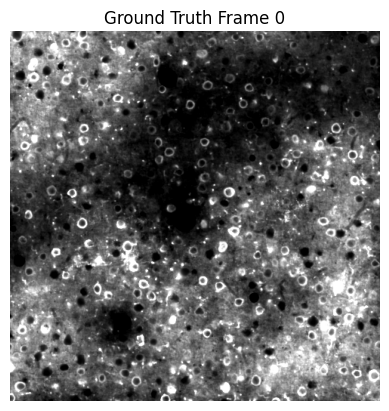

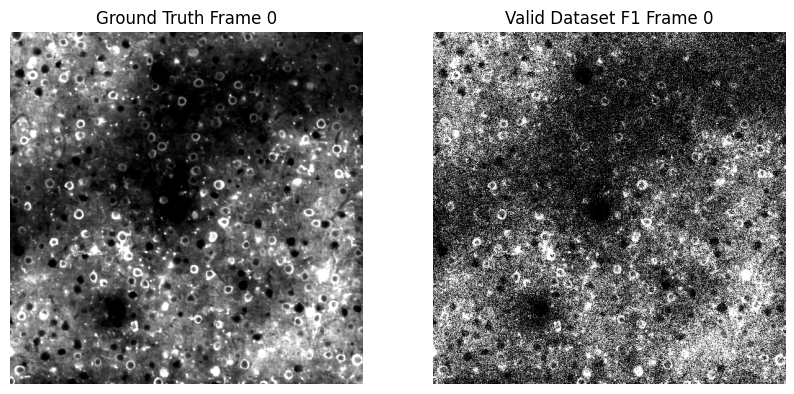

In [54]:
import matplotlib.pyplot as plt

def show_single_image(image, title="", vmin=None, vmax=None):
    plt.imshow(image, cmap="gray", vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.axis("off")
    plt.show()

def show_pair_images(image1, image2, title1="", title2="", vmin=None, vmax=None):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image1, cmap="gray", vmin=vmin, vmax=vmax)
    axes[0].set_title(title1)
    axes[0].axis("off")
    axes[1].imshow(image2, cmap="gray", vmin=vmin, vmax=vmax)
    axes[1].set_title(title2)
    axes[1].axis("off")
    plt.show()

show_single_image(ground_truth[0], title="Ground Truth Frame 0", vmin=global_vmin, vmax=global_vmax)
# show_single_image(valid_dataset.images[0][0], title="Valid Dataset F1 Frame 0", vmin=global_vmin, vmax=global_vmax)
show_pair_images(ground_truth[0], valid_dataset.images[0][0], title1="Ground Truth Frame 0", title2="Valid Dataset F1 Frame 0", vmin=global_vmin, vmax=global_vmax)

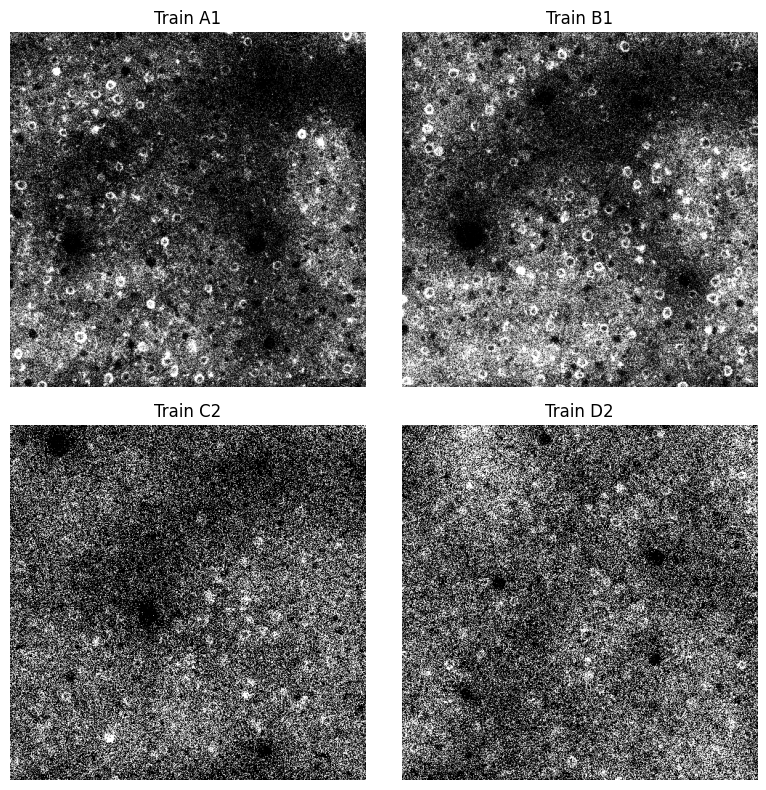

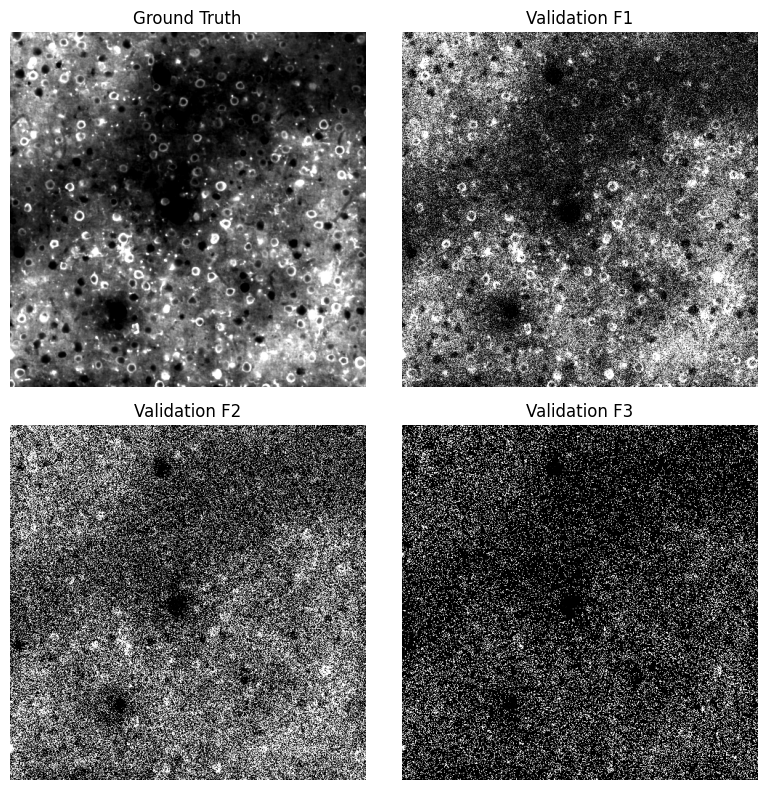

In [34]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for i in range(len(train_dataset.images)):
    image = train_dataset.images[i]

    axes[i//2, i%2].imshow(image[0], cmap="gray", vmin=global_vmin, vmax=global_vmax)
    axes[i//2, i%2].set_title(f"Train {sample_train_names[i]}")
    axes[i//2, i%2].axis("off")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes[0,0].imshow(ground_truth[0], cmap="gray", vmin=global_vmin, vmax=global_vmax)
axes[0,0].set_title(f"Ground Truth")
axes[0,0].axis("off")
for i in range(len(valid_dataset.images)):
    image = valid_dataset.images[i]

    ax_i = i + 1
    axes[ax_i//2, ax_i%2].imshow(image[0], cmap="gray", vmin=global_vmin, vmax=global_vmax)
    axes[ax_i//2, ax_i%2].set_title(f"Validation {sample_valid_names[i]}")
    axes[ax_i//2, ax_i%2].axis("off")
plt.tight_layout()
plt.show()

## Generate GIF animation

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

os.makedirs("animations", exist_ok=True)

def generate_gif(filename, data, fps=15, step=15):
    fig, ax = plt.subplots(figsize=(5, 5), dpi=72)

    sample = data[::step]

    im = ax.imshow(sample[0], cmap="gray", vmin=global_vmin, vmax=global_vmax)
    title = ax.set_title("Frame 0")
    ax.axis("off")
    fig.tight_layout()

    def animate(i):
        im.set_data(sample[i])
        title.set_text(f"Frame {i * step}")
        return [im, title]

    ani = animation.FuncAnimation(
        fig, animate, frames=len(sample), interval=1000/fps, blit=True)

    ani.save(filename, writer='pillow')
    plt.close()

def generate_nxn_gif(filename, dataset, titles, fps=15, step=15):
    n = 2
    fig, axes = plt.subplots(n, n, figsize=(8, 8), dpi=72)

    samples = [dataset[i][::step] for i in range(n * n)]

    fig.tight_layout()

    ims = []
    for i in range(n):
        for j in range(n):
            im = axes[i, j].imshow(samples[i * n + j][0], cmap="gray", vmin=global_vmin, vmax=global_vmax)
            axes[i, j].axis("off")
            axes[i, j].set_title(f"{titles[i * n + j]}")
            ims.append(im)

    def animate(frame):
        for idx, im in enumerate(ims):
            im.set_data(samples[idx][frame])
        return ims

    ani = animation.FuncAnimation(
        fig, animate, frames=len(samples[0]), interval=1000/fps, blit=True)

    ani.save(filename, writer='pillow')
    plt.close()

train_titles = [f"Train {name}" for name in sample_train_names]
valid_titles = ["Ground Truth"] + [f"Validation {name}" for name in sample_valid_names]

# generate_gif("animations/ground_truth.gif", ground_truth)
generate_nxn_gif("animations/train_samples.gif", train_dataset.images, train_titles)
generate_nxn_gif("animations/valid_samples.gif", [ground_truth] + valid_dataset.images, valid_titles)

# Inference Evaluation

For faster evaluation, you should use **GPU** to run below blocks.

In [56]:
import os

os.makedirs("demo", exist_ok=True)

""" check models in demo folder """
demo_models = os.listdir("demo")
print(demo_models)

['nmode_best_model_state_dict.pth']


In [ ]:
import torch
from model_arch.unet import UNet, UNet3D, UNetnmODE

eval_model = torch.load("demo/nmode_best_model_state_dict.pth")